In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/ISBI2016/train/'
test_dir = '/content/drive/MyDrive/ISBI2016/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

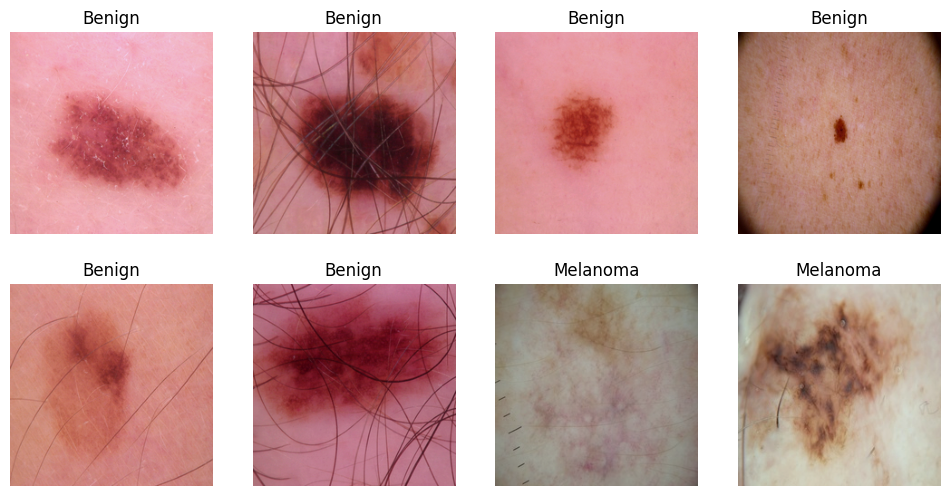

In [ ]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:

# Define the base model from Xception
base_model = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few
for layer in base_model.layers:
    layer.trainable = False
# Set the last Xception block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the Xception base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 3,426,178 (13.07 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

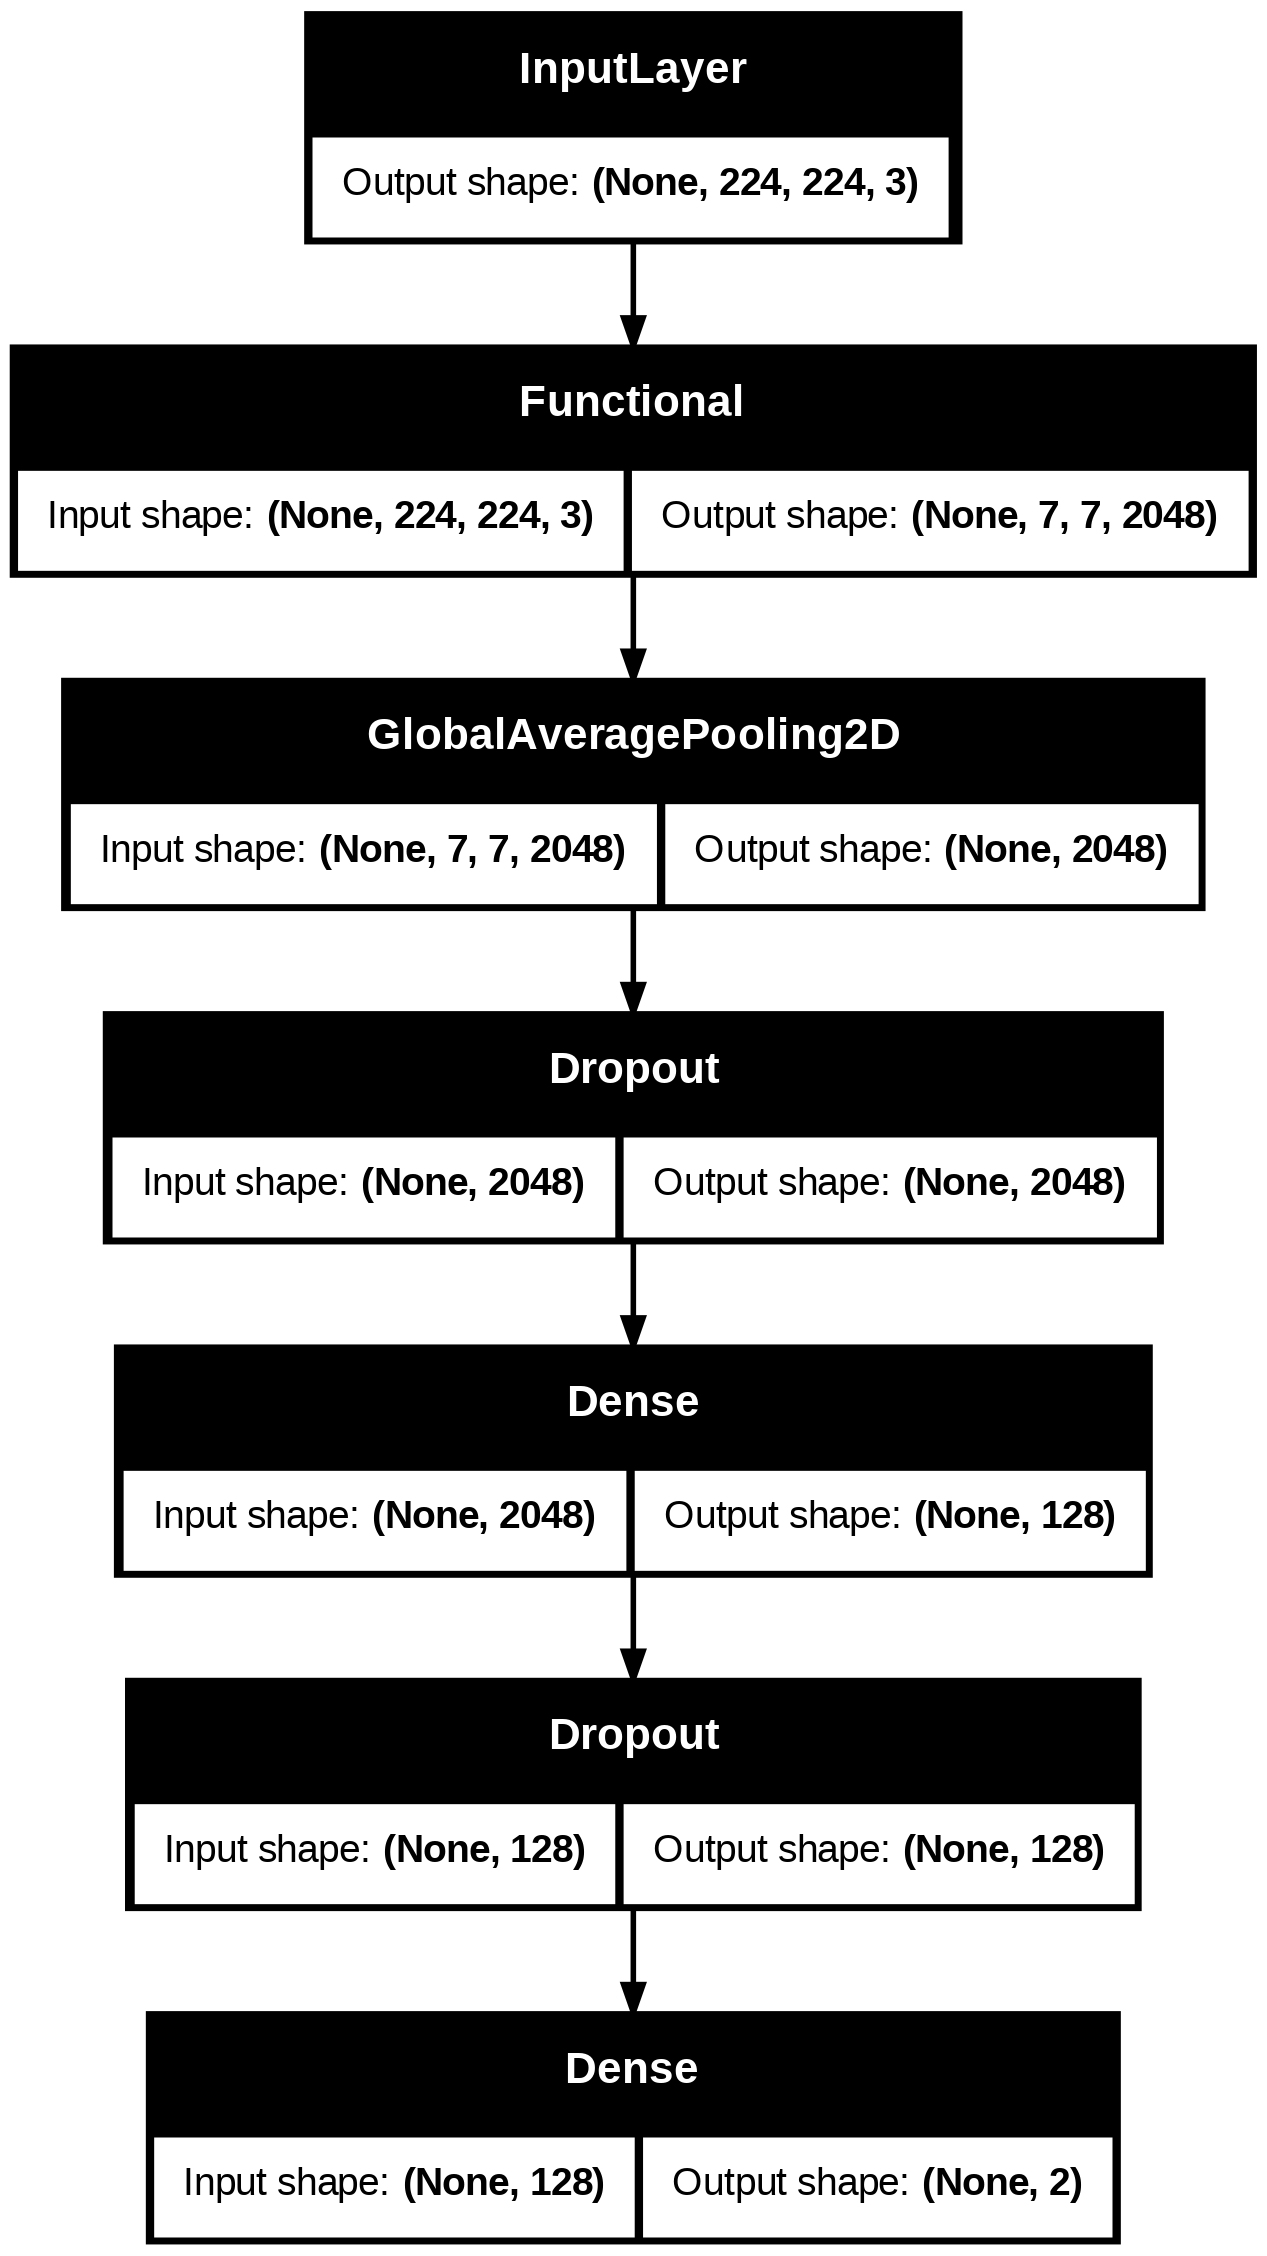

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: 0.5403 - sparse_categorical_accuracy: 0.7165
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9167
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9318
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.1390 - sparse_categorical_accuracy: 0.9474
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9629
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9735
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9839
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9897
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9910
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - l

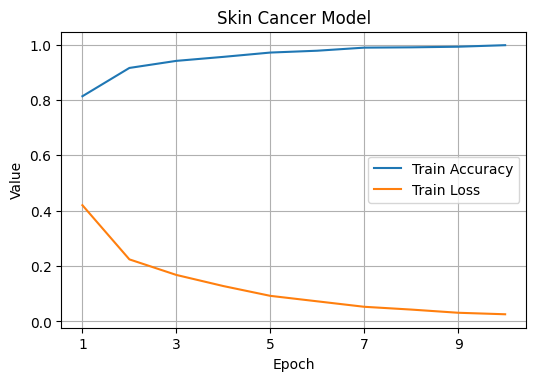

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.grid()
ax1.set_xticks(np.arange(1, 11, 2))
ax1.set_ylabel('Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Skin Cancer Model')
l1 = ax1.legend(loc="best")
plt.savefig('curve1',dpi=400)

# Federated Learning Based transfer Learning enabled MobileNet Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0166 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9939
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - loss: 0.0100 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0074 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0046 - sparse_categorical_accuracy: 1.0000
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - loss: 0.0236 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9992
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9982
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0104 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.

  0%|          | 0/11 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  9%|▉         | 1/11 [00:17<02:59, 17.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 2/11 [00:26<01:50, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 3/11 [00:35<01:28, 11.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 4/11 [00:43<01:09,  9.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▌     | 5/11 [00:51<00:54,  9.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▍    | 6/11 [00:59<00:43,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 7/11 [01:06<00:32,  8.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 8/11 [01:15<00:24,  8.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 9/11 [01:23<00:16,  8.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 10/11 [01:31<00:08,  8.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|██████████| 11/11 [01:38<00:00,  7.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


12it [01:55,  9.62s/it]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.88      0.99      0.93       304
    Melanoma       0.94      0.45      0.61        75

    accuracy                           0.89       379
   macro avg       0.91      0.72      0.77       379
weighted avg       0.89      0.89      0.87       379



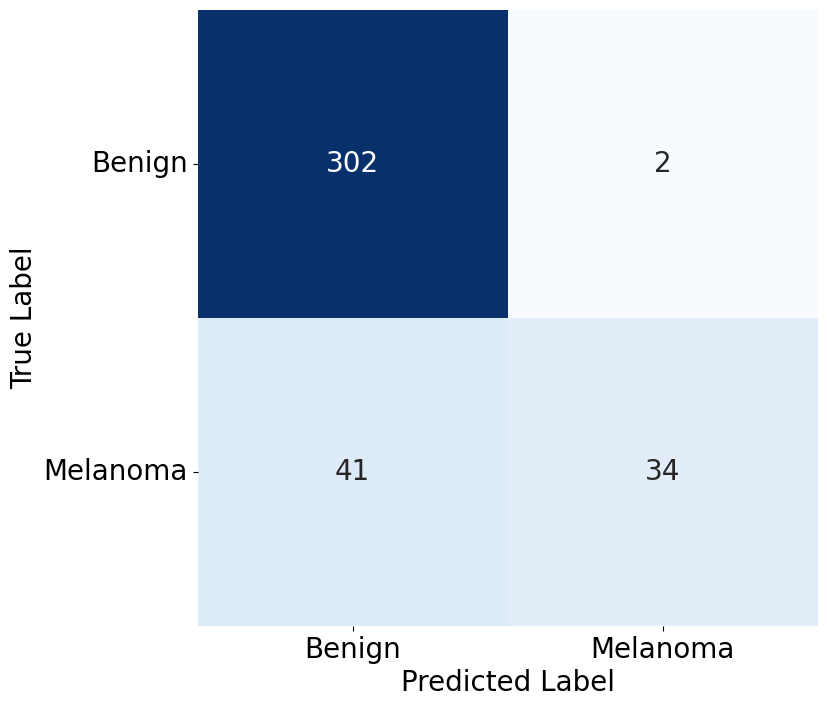

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 34.000000 TN: 302.000000 FP: 2.000000 FN: 41.000000


In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 0.88654
Specificity: 0.99342
 Recall: 0.45333
 Precision: 0.94444
F1 Score: 0.61261


# Improved Code of Transfer Learning Based MobileNet Model

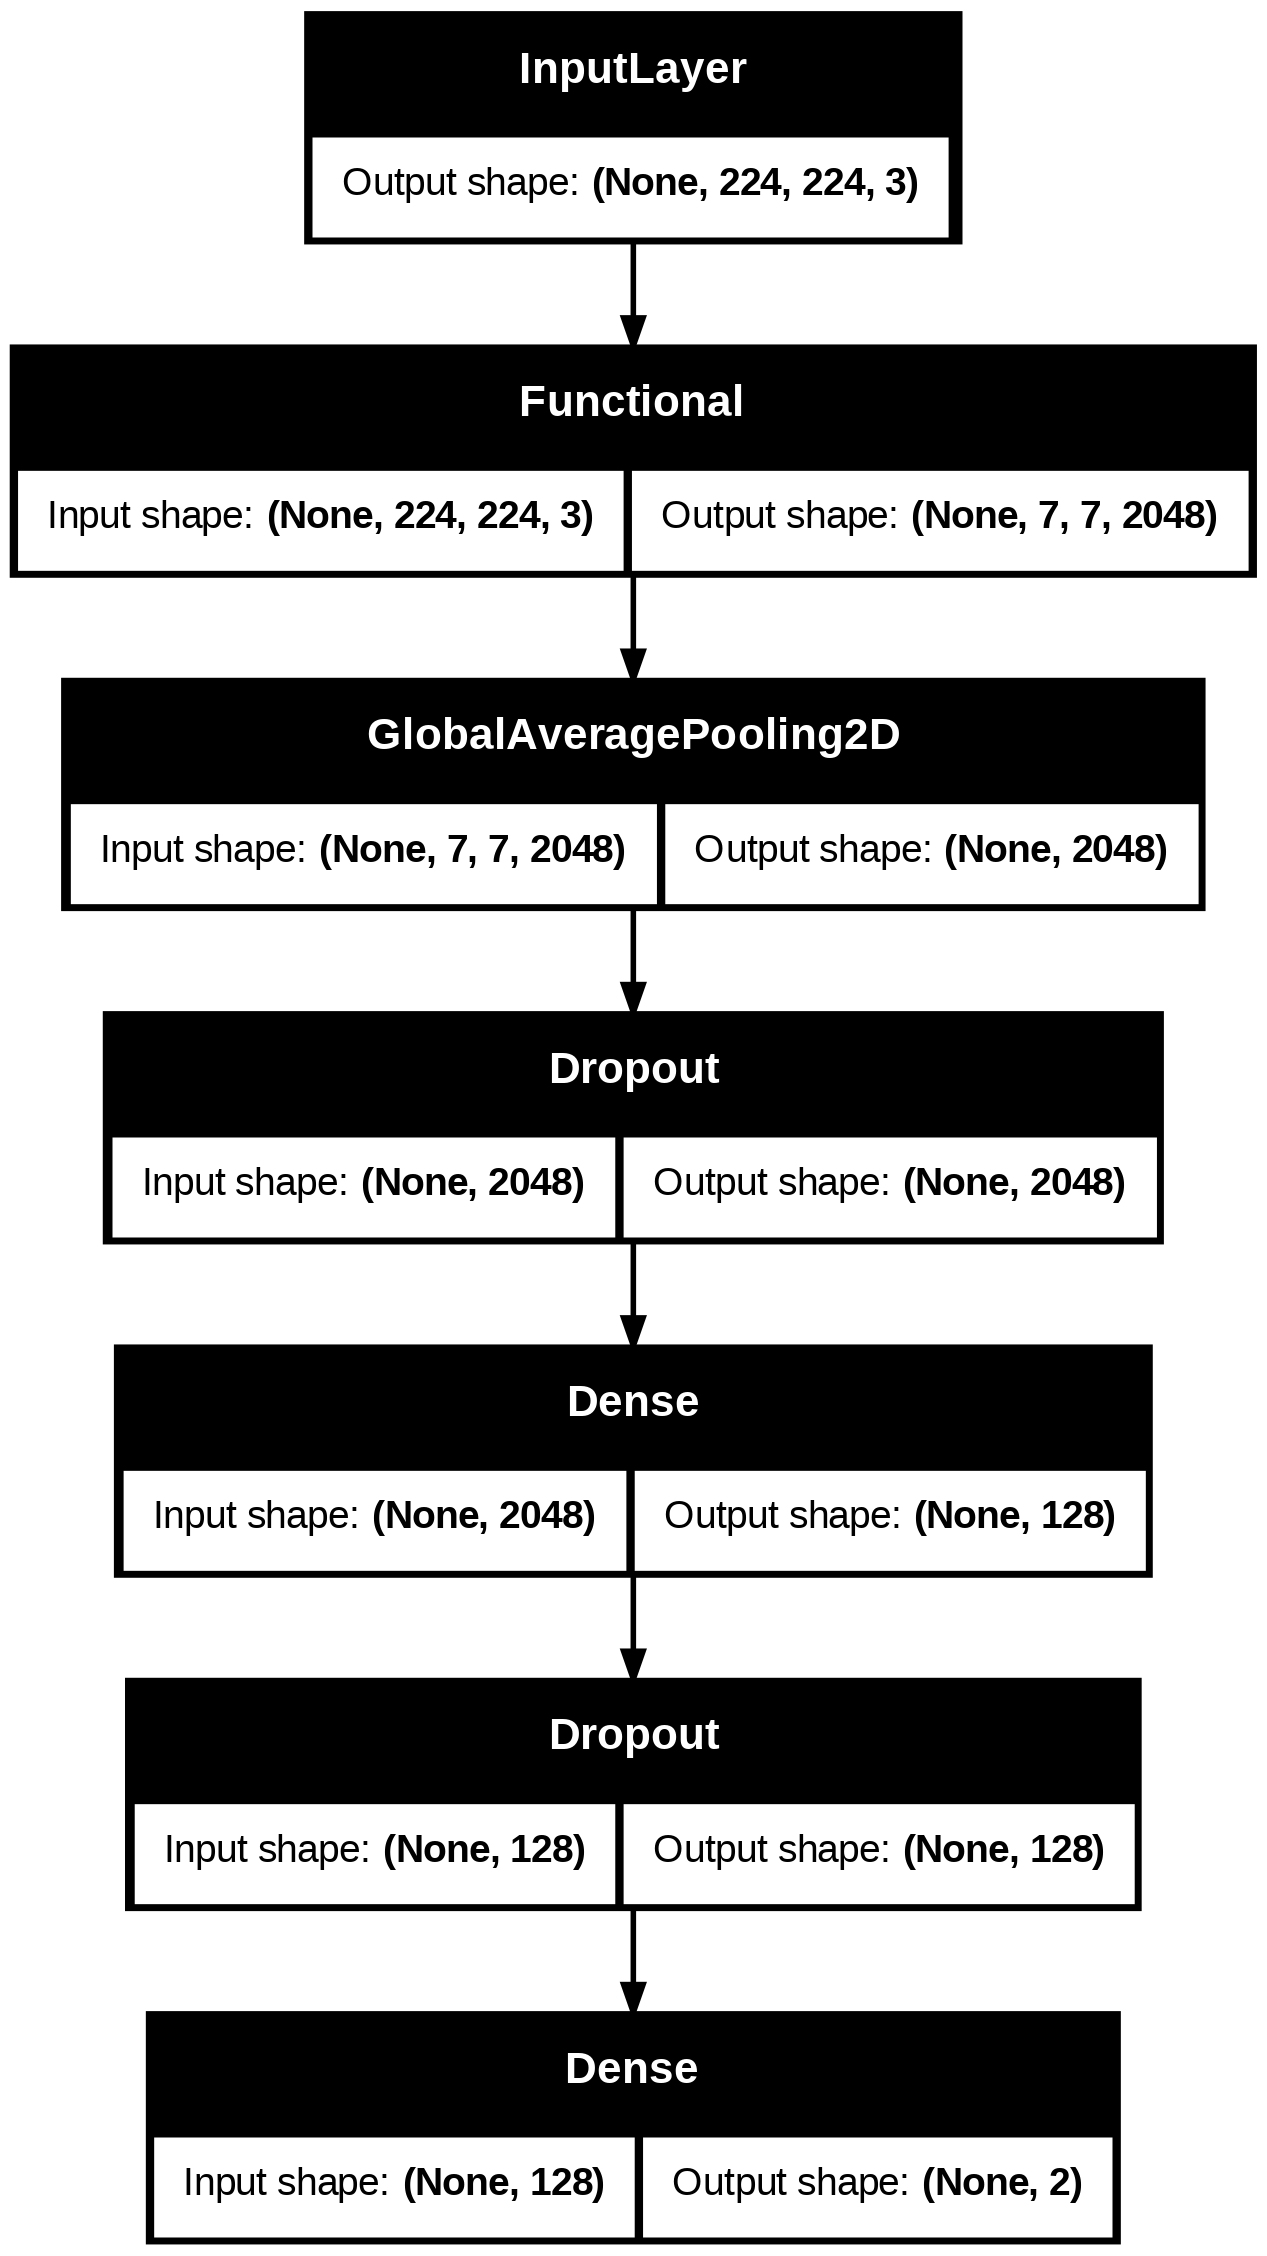

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9983
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9987
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - loss: 0.0044 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.0016 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.0022 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 9.1693e-04 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9989
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/s

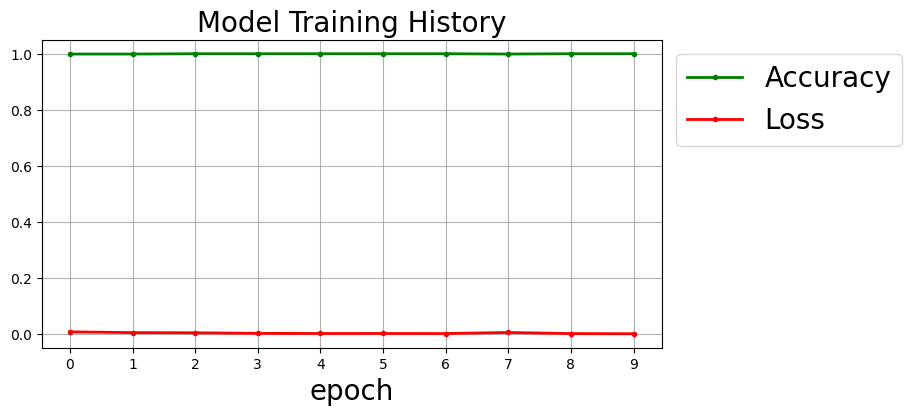

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/11 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  9%|▉         | 1/11 [00:02<00:29,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 2/11 [00:03<00:13,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 27%|██▋       | 3/11 [00:04<00:08,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 36%|███▋      | 4/11 [00:04<00:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 5/11 [00:05<00:04,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 55%|█████▍    | 6/11 [00:05<00:03,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▎   | 7/11 [00:06<00:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 73%|███████▎  | 8/11 [00:06<00:01,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 9/11 [00:06<00:01,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 10/11 [00:07<00:00,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|██████████| 11/11 [00:07<00:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


12it [00:10,  1.13it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.89      0.97      0.93       304
    Melanoma       0.83      0.51      0.63        75

    accuracy                           0.88       379
   macro avg       0.86      0.74      0.78       379
weighted avg       0.88      0.88      0.87       379



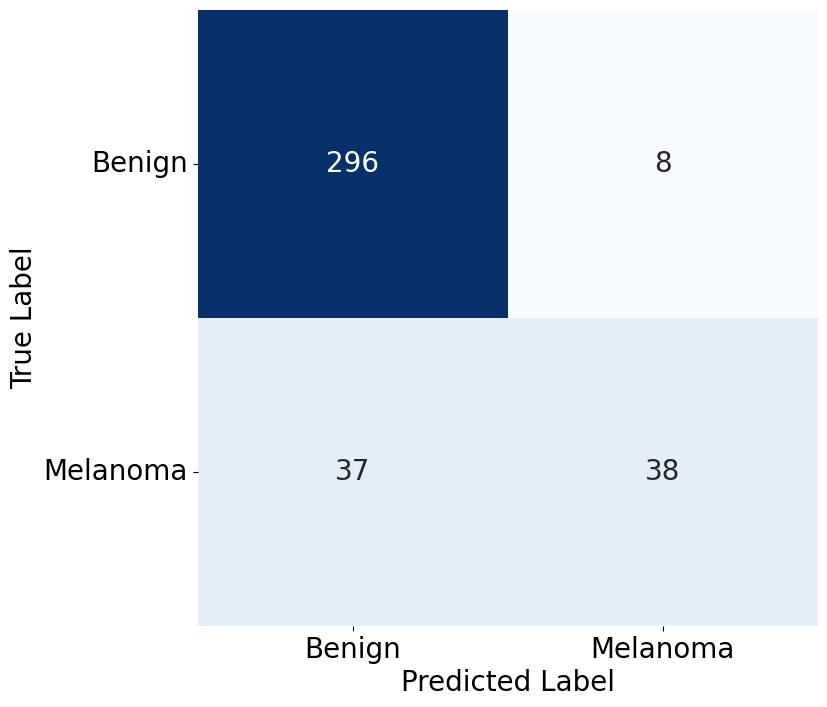

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


TP: 38.000000 TN: 296.000000 FP: 8.000000 FN: 37.000000
acc: 0.88127
Specificity: 0.97368
 Recall: 0.50667
 Precision: 0.82609
F1 Score: 0.62810


In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
TP=38
TN=296
FP=8
FN=37
# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")


AUC: 0.74018
MCC: 0.58604
Cohen's Kappa: 0.56223


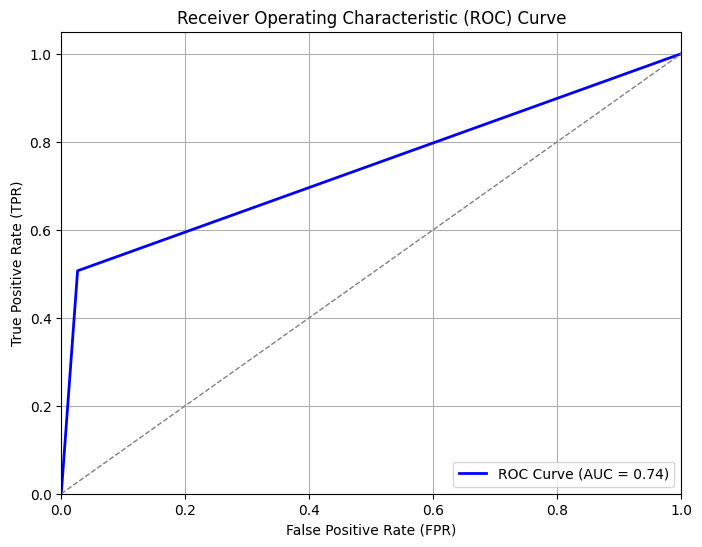

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()
